In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

%matplotlib inline
fig_size = [16, 7]
plt.rcParams["figure.figsize"] = fig_size

In [2]:
# Load data
filepath = "data/data.csv"
raw_data = pd.read_csv(filepath, dayfirst=True, parse_dates=[["Date", "Time"]])

# Datetime processing
raw_data["CW"] = raw_data.Date_Time.dt.weekofyear
data = raw_data.set_index(pd.DatetimeIndex(raw_data.Date_Time)).drop("Date_Time", axis=1)

# First and last day of measurements for report heading
first_day = data.index[0].strftime("%d.%m.%Y")
last_day = data.index[-1].strftime("%d.%m.%Y")

data.head()

,Sys,Dia,Pulse,CW
Date_Time,,,,
2017-07-15 09:16:00,148,84,57,28
2017-07-15 19:24:00,159,92,75,28
2017-07-15 22:23:00,123,83,77,28
2017-07-16 09:14:00,124,81,68,28
2017-07-16 15:16:00,121,79,70,28


# Report - Blood Pressure Monitoring
Measurements between {{first_day}} and {{last_day}}

### Blood Pressure & Pulse Values
Visualization

In [3]:
# Plot Util 

def make_week_plot(week, df):
    """ Creates plot object of weekly pressure and pulse values
    :Param week: calendar week [Int]
    :Param df: pd.Dataframe of pressure and pulse values per week
    :Return plt: Pyplot object
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots()

    for ix, row in df.iterrows():
        # Pulse point marker
        pulse_plot, = ax.plot(ix, row.Pulse, 
                             marker="D", color="m", linestyle = "None", label="Pulse")
        # Sys point marker
        sys_plot, = ax.plot(ix, row.Sys,
                           marker="v", color="b", linestyle = "None", label="Systolic")
        # Dia point marker
        dia_plot, = ax.plot(ix, row.Dia,
                           marker="^", color="b", linestyle = "None", label="Diastolic")
        # Vertical line between points
        vert_plot = ax.axvline(x=ix, ymin=row.Dia/220, ymax=row.Sys/220, 
                               color="b")

    # X Axis enhancements
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("\n\n\n\n%d\n%a"))
    ax.xaxis.grid(True, which="minor")
    for xmin in ax.xaxis.get_minorticklocs():
        ax.axvline(x=xmin, linestyle="-.", linewidth=1, color="k", alpha=0.4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.xticks(rotation=270)

    # Y Axis enhancements
    plt.yticks(range(0, 221, 20))

    # Title
    ax.set_title("Calendar Week " + str(week), fontsize= 15, fontweight="bold")
    
    # Legend
    legend = plt.legend([sys_plot, dia_plot, pulse_plot], ["Systolic", "Diastolic", "Pulse"],
                        loc=4, markerscale=1.6, frameon=True, fontsize=13)
    frame = legend.get_frame()
    frame.set_color("w")
    
    # Layout
    plt.tight_layout()
    
    return plt


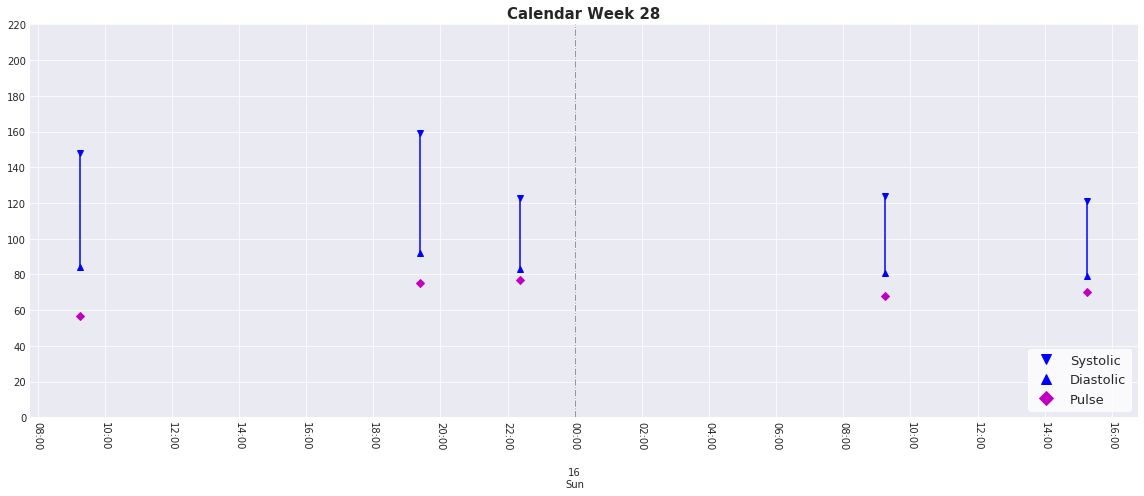

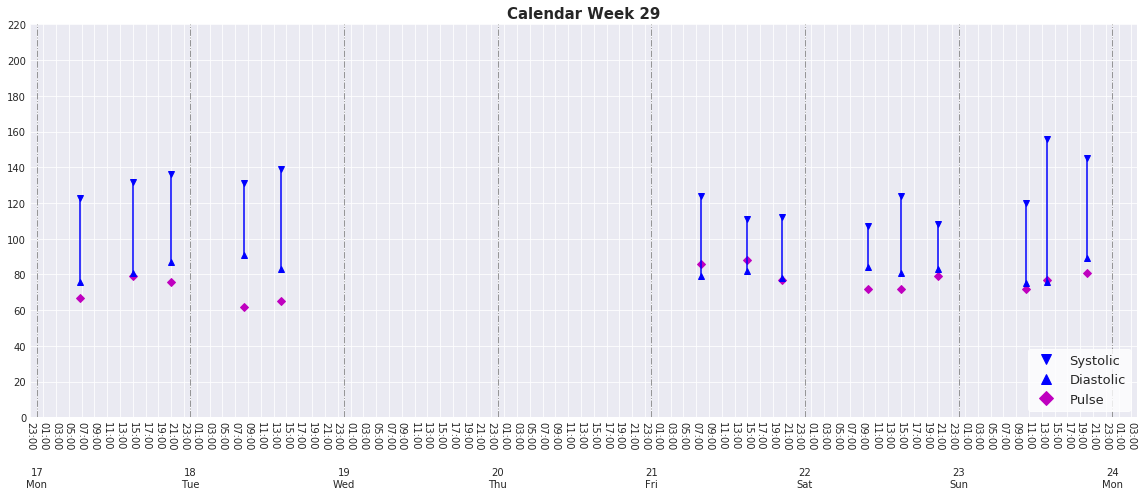

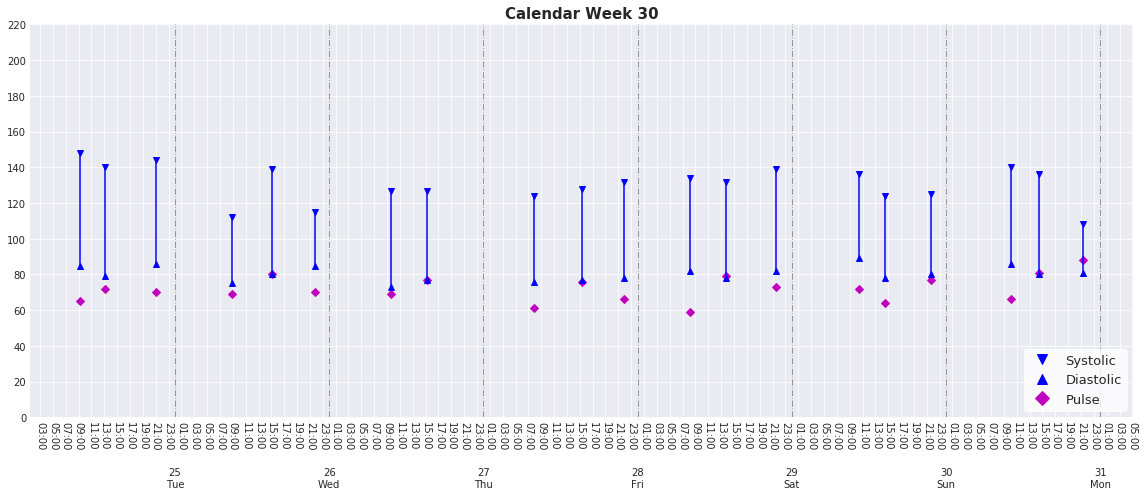

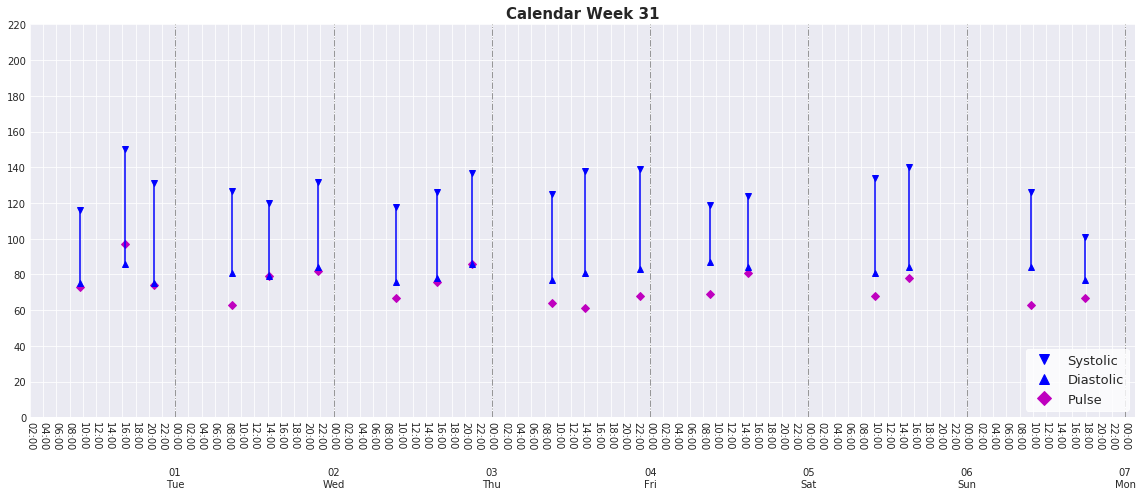

In [4]:
for k,v in data.groupby("CW"):
    p = make_week_plot(week=k, df=v)
    p.show()

#### Metrices

In [5]:
# Metrices Utils

def make_metrices_dict(df):
    """ Creates dict of standard metrices and corresponding values
    :Param data: pd.Dataframe of pressure values
    :Return metrices dict: dict with metrices and processed values 
    """
    metrices_dict = {}

    #number of measures
    metrices_dict["Number of Measures"] = df.shape[0]
    
    #mean
    metrices_dict["Systolic mean"] = "{0:.2f}".format(df.Sys.mean())
    metrices_dict["Diastolic mean"] = "{0:.2f}".format(df.Dia.mean())

    #sys max min
    metrices_dict["Systolic max"] = df.Sys.max()
    metrices_dict["Systolic min"] = df.Sys.min()

    #dia max min
    metrices_dict["Diastolic max"] = df.Dia.max()
    metrices_dict["Diastolic min"] = df.Dia.min()
    
    #count of high / low blood pressure measures
    metrices_dict["High Pressure Measures"] = df[(df.Sys > 139) | (df.Dia > 89)].count()[0]
    metrices_dict["High Pressure Measures Rate"] = "{:.0%}".format(metrices_dict["High Pressure Measures"] / 
                                                                    metrices_dict["Number of Measures"])
    metrices_dict["Low Pressure Measures"] = df[(df.Sys < 100) | (df.Dia < 60)].count()[0]
    metrices_dict["Low Pressure Measures Rate"] = "{:.0%}".format(metrices_dict["Low Pressure Measures"] / 
                                                                    metrices_dict["Number of Measures"])
    
    #pulse measures
    metrices_dict["Pulse mean"] = "{0:.2f}".format(df.Pulse.mean())
    metrices_dict["Pulse max"] = df.Pulse.max()
    metrices_dict["Pulse min"] = df.Pulse.min()
    
    return metrices_dict


Total

In [6]:
# Metrices Total
metrices_total = make_metrices_dict(data)

metrices_table_total = pd.DataFrame.from_dict(metrices_total, orient="index").rename(columns={0: "Value"})
metrices_table_total

,Value
Number of Measures,57
Systolic mean,129.05
Diastolic mean,81.21
Systolic max,159
Systolic min,101
Diastolic max,92
Diastolic min,73
High Pressure Measures,11
High Pressure Measures Rate,19%
Low Pressure Measures,0


Per Week

In [7]:
# Metrices per Week
metrices_weeks = pd.DataFrame()

for k,v in data.groupby("CW"):
    metrices_week = pd.DataFrame.from_dict(make_metrices_dict(v), orient="index")
    metrices_weeks = pd.concat([metrices_weeks, metrices_week], 1, ignore_index=True)

metrices_weeks.columns = data.CW.unique()
metrices_weeks

,28,29,30,31
Number of Measures,5,14,20,18
Systolic mean,135.00,126.29,130.50,127.94
Diastolic mean,83.80,81.79,80.35,81.00
Systolic max,159,156,148,150
Systolic min,121,107,108,101
Diastolic max,92,91,89,87
Diastolic min,79,75,73,75
High Pressure Measures,2,3,4,2
High Pressure Measures Rate,40%,21%,20%,11%
Low Pressure Measures,0,0,0,0


### Data Table

In [8]:
# Data table
data_table = data
data_table.drop("CW", 1, inplace=True)
data_table.index.rename("ToM", inplace=True)

#with pd.option_context('display.max_rows', 999, 'display.max_columns', 5):
#    print df
    
pd.option_context("display.max_rows", 200)
data_table

,Sys,Dia,Pulse
ToM,,,
2017-07-15 09:16:00,148,84,57
2017-07-15 19:24:00,159,92,75
2017-07-15 22:23:00,123,83,77
2017-07-16 09:14:00,124,81,68
2017-07-16 15:16:00,121,79,70
2017-07-17 06:45:00,123,76,67
2017-07-17 15:04:00,132,81,79
2017-07-17 21:00:00,136,87,76
2017-07-18 08:20:00,131,91,62
